In [29]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [43]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip;

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-12-05 12:31:57--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.4’

cats_and_dogs.zip.4 100%[===================>]  67.43M  63.1MB/s    in 1.1s    

2024-12-05 12:31:58 (63.1 MB/s) - ‘cats_and_dogs.zip.4’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/cats_and_dogs/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [31]:
# 3
# ImageDataGenerators for rescaling image pixel values to [0, 1]
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

# Parameters (commented out but typically used for training)
# batch_size = 128
# epochs = 15
# IMG_HEIGHT = 150
# IMG_WIDTH = 150

# Load and preprocess training data
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,  # Data batch size
    directory=train_dir,  # Training data directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images
    class_mode='binary'  # Binary classification
)

# Load and preprocess validation data
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,  # Data batch size
    directory=validation_dir,  # Validation data directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images
    class_mode='binary'  # Binary classification
)

# Load and preprocess test data (no shuffling, used for predictions)
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,  # Data batch size
    directory=PATH,  # Test data directory
    classes=['test'],  # Test images subdirectory
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images
    class_mode="input",  # Input images only (for predictions)
    shuffle=False  # Don't shuffle for consistent evaluation
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


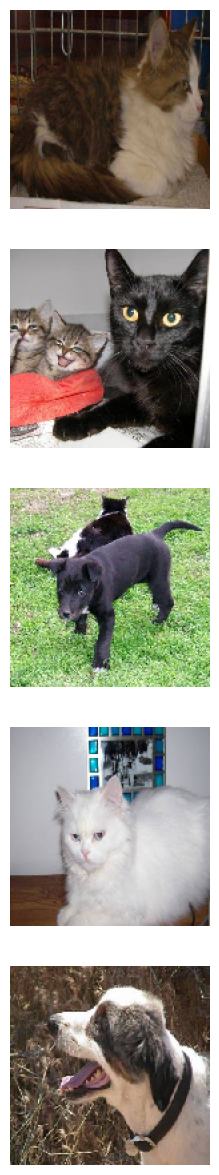

In [32]:
# 4
# Function to plot images along with their predicted probabilities (if provided)
def plotImages(images_arr, probabilities=False):
    # Create subplots to display images in a grid format (one row per image)
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    if probabilities is False:  # If no probabilities are provided, just display images
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)  # Display the image on the axis
            ax.axis('off')  # Hide axis labels and ticks
    else:  # If probabilities are provided, display them as titles
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)  # Display the image on the axis
            ax.axis('off')  # Hide axis labels and ticks
            # Set the title with the predicted probability
            if probability > 0.5:  # If the probability of dog is greater than 50%
                ax.set_title("%.2f" % (probability * 100) + "% dog")  # Display as dog
            else:  # If the probability of cat is greater
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")  # Display as cat

    plt.show()  # Show the plot with all images

# Get a batch of images from the training data generator
sample_training_images, _ = next(train_data_gen)
# Display the first 5 images from the batch without probabilities
plotImages(sample_training_images[:5])


In [33]:
# 5
# Create an ImageDataGenerator instance for training data augmentation and preprocessing
train_image_generator = ImageDataGenerator(
    rescale=1/255,                # Normalize the pixel values to the range [0, 1] by scaling them
    fill_mode="nearest",          # Specify how to fill newly created pixels after shifting or rotating images. "nearest" fills with the nearest pixel's value
    horizontal_flip=True,         # Randomly flip the images horizontally (left-right flip)
    vertical_flip=True,           # Randomly flip the images vertically (top-bottom flip)
    width_shift_range=0.3,        # Randomly shift the image horizontally (left-right) within 30% of the total width
    height_shift_range=0.3,       # Randomly shift the image vertically (top-bottom) within 30% of the total height
    zoom_range=0.25,              # Randomly zoom into the image, scaling by up to 25%
    shear_range=0.25              # Randomly shear (slant) the image by up to 25%
)


Found 2000 images belonging to 2 classes.


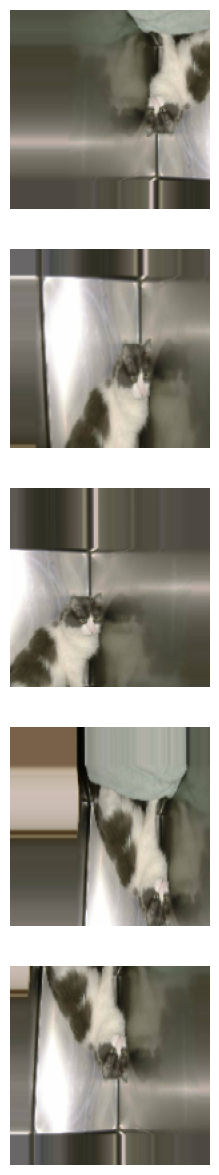

In [34]:
# 6
# Create a data generator that loads the images from the directory and applies the augmentations specified earlier
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,                      # The number of images to process per batch
    directory=train_dir,                        # Directory where the training images are located
    target_size=(IMG_HEIGHT, IMG_WIDTH),        # Resize the images to the target size (IMG_HEIGHT x IMG_WIDTH)
    class_mode='binary'                         # The labels are binary (dog or cat)
)

# Fetch the first batch of images and select the first image from that batch
augmented_images = [train_data_gen[0][0][0] for i in range(5)]  # Take the first 5 augmented images

# Visualize the augmented images using the plotImages function
plotImages(augmented_images)


In [35]:
# 7
# Define a Sequential model in Keras
model = Sequential()

# Add a Convolutional layer with 32 filters, each of size 3x3, ReLU activation function
# This layer will look for features in the image, with the input size being 150x150 pixels and 3 color channels (RGB)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Add a MaxPooling layer with a 2x2 pool size to reduce the spatial dimensions of the image
# This helps to downsample the image and keep the important features
model.add(MaxPooling2D((2, 2)))

# Add another Convolutional layer with 64 filters, each of size 3x3, ReLU activation function
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer to reduce the image dimensions further
model.add(MaxPooling2D((2, 2)))

# Add a third Convolutional layer with 128 filters, each of size 3x3, ReLU activation function
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another MaxPooling layer to continue downsampling the image
model.add(MaxPooling2D((2, 2)))

# Flatten the 3D output (height, width, channels) of the last convolutional layer into a 1D vector
# This prepares the data for the fully connected (Dense) layers
model.add(Flatten())

# Add a Dense (fully connected) layer with 64 neurons
# This layer learns from the features extracted by the convolutional layers
model.add(Dense(64))

# Add the output layer with 2 neurons (since it's a binary classification problem)
# The final layer has 2 neurons because we have two classes (dog and cat)
model.add(Dense(2))

# Compile the model:
# - Adam optimizer is used for training the model.
# - Accuracy is tracked as the evaluation metric.
# - SparseCategoricalCrossentropy is used as the loss function (because we're dealing with multi-class classification and integer labels).
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))

# Print a summary of the model to view the architecture (number of parameters, layers, etc.)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       2,367,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
total_train//batch_size, total_val//batch_size, total_train, total_val, batch_size


(15, 7, 2001, 1001, 128)

In [38]:
# 8
# The following line would normalize the training data by dividing the pixel values by 255 to scale them to the range [0, 1].
# However, this is already done in the ImageDataGenerator definition, so it's commented out here to avoid redundancy.
# train_data_gen /= 255
# validation_data /= 255

# Train the model using the training data generator (train_data_gen)
# - `steps_per_epoch`: Specifies how many steps to run for each epoch. The total number of training samples divided by the batch size.
# - `epochs`: The number of times the entire training dataset will be passed through the model.
# - `validation_data`: The validation data generator (val_data_gen) used to evaluate the model after each epoch.
# - `validation_steps`: The number of steps to run for validation data, calculated as the total number of validation samples divided by the batch size.
# - `verbose=1`: Controls the verbosity of the output. Setting it to 1 will show a progress bar with updates during training.

history = model.fit(
    train_data_gen,                      # The training data generator
    steps_per_epoch=total_train // batch_size,  # The number of steps per epoch (total training samples divided by batch size)
    epochs=epochs,                       # Number of epochs to train for
    validation_data=val_data_gen,        # Validation data generator
    validation_steps=total_val // batch_size, # Number of steps per validation (total validation samples divided by batch size)
    verbose=1                            # Display training progress with a progress bar
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.5629 - loss: 0.6760 - val_accuracy: 0.5770 - val_loss: 0.6669
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5938 - loss: 0.6749 - val_accuracy: 0.6635 - val_loss: 0.6895
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.5857 - loss: 0.6705 - val_accuracy: 0.6440 - val_loss: 0.6296
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6172 - loss: 0.6705 - val_accuracy: 0.5673 - val_loss: 0.6762
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.6002 - loss: 0.6645 - val_accuracy: 0.6395 - val_loss: 0.6639
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.4688 - loss: 0.7504 - val_accuracy: 0.7019 - val_loss: 0.6521
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.5974 - loss: 0.6713 - val_accuracy: 0.5759 - val_loss: 0.6454
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5625 - loss: 0.6726 - val_accuracy: 0.6346 - v

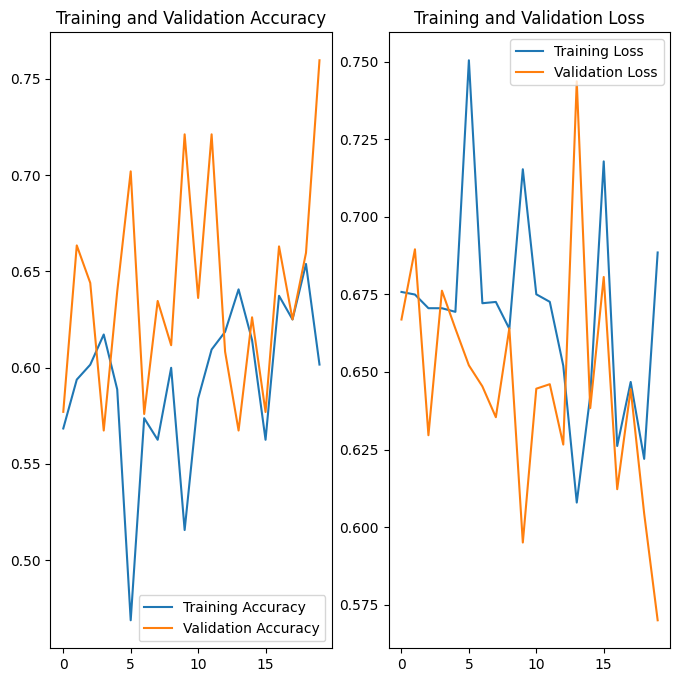

In [39]:
# 9
# Extract accuracy and loss values for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


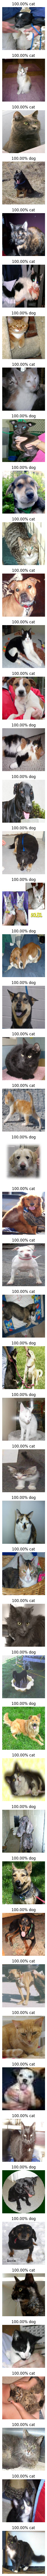

In [41]:
test_images, _ = next(test_data_gen)
# print(test_images,_)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
# print(model.predict(test_data_gen))
plotImages(test_images, probabilities=probabilities)

In [42]:
# 11
# List of actual answers (0 = cat, 1 = dog)
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

# Compare the predicted probabilities with the actual answers
for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct += 1

# Calculate the percentage of correctly identified images
percentage_identified = (correct / len(answers)) * 100

# Check if the model passed the challenge
passed_challenge = percentage_identified >= 63

# Output the results
print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
